In [19]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[len(quantiles) // 2 +1] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [4]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


# proper vs strictly proper for SIR curve

In [5]:
# SIR Model in homogeneous single population
# input is the number of stochastic simulations to run, the transmissibility parameter, the recovery rate, 
# population size, and number of initially infected individuals
def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        # initial conditions
        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) ) # force of infection
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu)) # recovery
            
            # update compartments
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            # create time series of compartment counts
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        # save all simulations in a dictionary
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



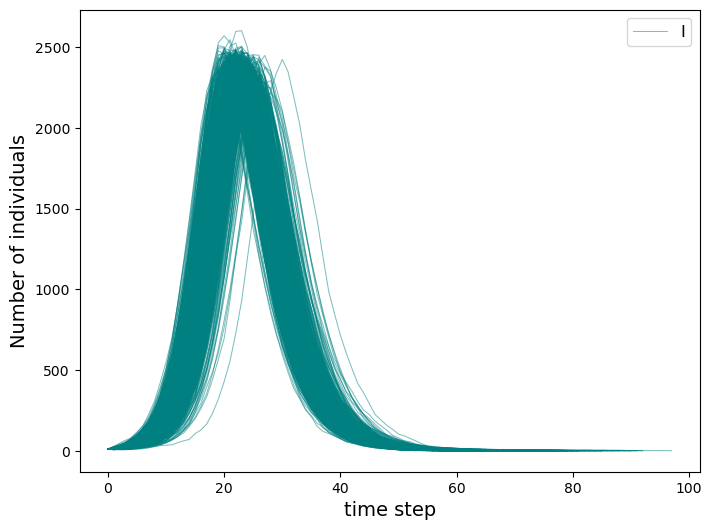

In [6]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =1000
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [7]:
# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1

In [8]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

In [9]:
# reshuffle trajectories to create uncorrelated model

I_uncorr = pd.DataFrame()
for t in Idf.time.unique():
    a = list(Idf[Idf.time==t]['I']) 
    val = np.random.choice(a,100, replace=False)

    newrow = pd.DataFrame({'trajectory_id':list(range(1,101)), 'time':np.ones(100)*t, 'I':val})
    I_uncorr = pd.concat([I_uncorr, newrow])

In [10]:
I_uncorr

,trajectory_id,time,I
0,1,1.0,10
1,2,1.0,10
2,3,1.0,10
3,4,1.0,10
4,5,1.0,10
...,...,...,...
95,96,60.0,1
96,97,60.0,4
97,98,60.0,3
98,99,60.0,3


In [ ]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))
for i in I_uncorr.trajectory_id.unique():
    if i<500:
        d = I_uncorr[I_uncorr.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)

Text(0.5, 0, 'Time')

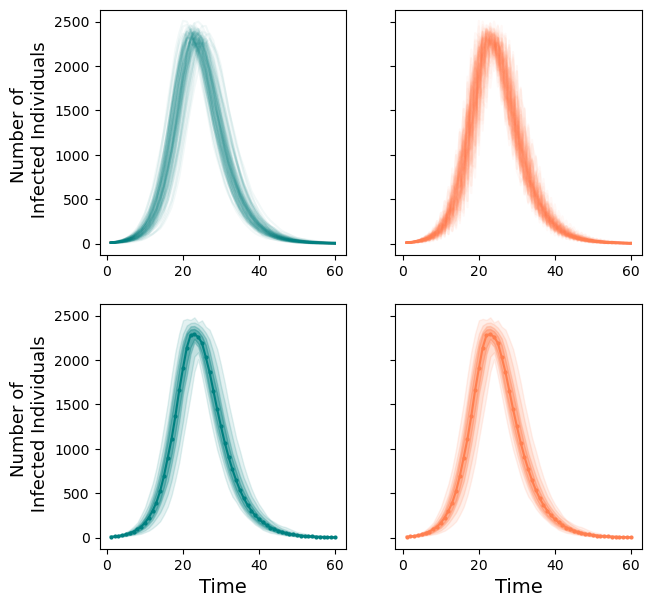

In [11]:
# plot all trajectories
fig = plt.subplots(2,2, figsize=(7,7), sharey=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in I_uncorr.trajectory_id.unique():
    if i<501:
        d = I_uncorr[I_uncorr.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(I_uncorr.groupby('time')['I'].quantile(q[0]))
    qlow = list(I_uncorr.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(I_uncorr.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(I_uncorr.groupby('time')['I'].quantile(.5))

plt.plot(I_uncorr.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
 

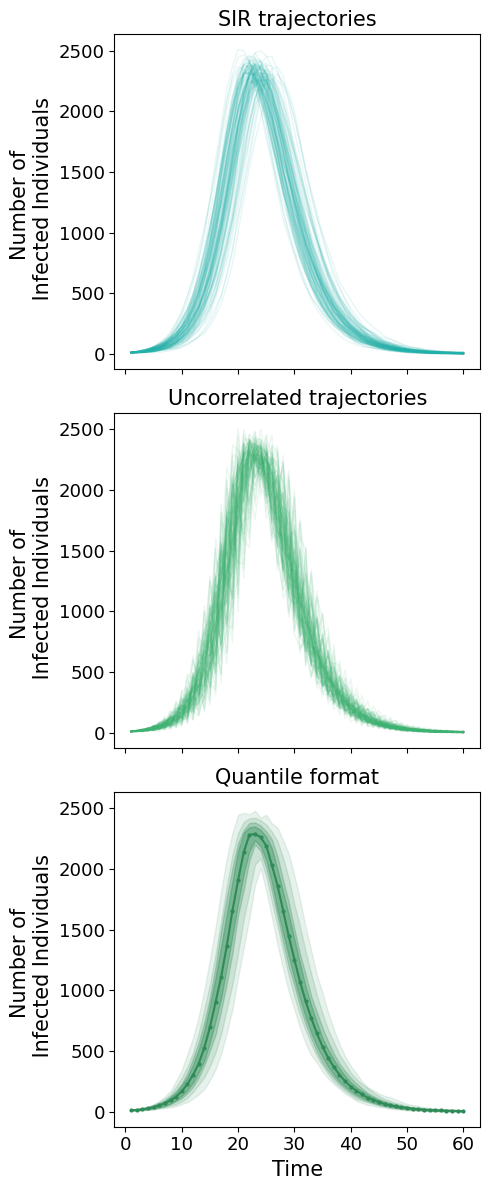

In [12]:
# plot all trajectories
mpl.rc_file_defaults()
fig = plt.subplots(3,1, figsize=(5,12), sharey=True, sharex=True)

plt.subplot(3,1,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='lightseagreen', alpha=.1, linewidth=1)
#plt.xlabel('Time', fontsize=15)
plt.ylabel('Number of \n Infected Individuals', fontsize=15)
plt.xticks(fontsize=13)  
plt.yticks(fontsize=13)
plt.title('SIR trajectories', fontsize=15)

plt.subplot(3,1,2)
for i in I_uncorr.trajectory_id.unique():
    if i<501:
        d = I_uncorr[I_uncorr.trajectory_id==i]
        plt.plot(d.time, d.I, color='mediumseagreen', alpha=.1, linewidth=1)
#plt.xlabel('Time', fontsize=15)        
plt.xticks(fontsize=13) 
plt.title('Uncorrelated trajectories', fontsize=15)
plt.ylabel('Number of \n Infected Individuals', fontsize=15)
plt.yticks(fontsize=13)
        
plt.subplot(3,1,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='seagreen', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='seagreen', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Number of \n Infected Individuals', fontsize=15)
plt.yticks(fontsize=13)
 
plt.xticks(fontsize=13)
plt.title('Quantile format', fontsize=15)

plt.tight_layout()
#plt.savefig('../figs/SIR_uncorr_traj_R02_5_vert.pdf')


In [13]:
Idf['Model'] = 'SIR'
I_uncorr['Model'] = 'uncorrelated'

dftot = pd.concat([Idf, I_uncorr])



In [14]:
dftot

,trajectory_id,time,I,Model
0,1,1.0,10,SIR
0,1,2.0,9,SIR
0,1,3.0,14,SIR
0,1,4.0,13,SIR
0,1,5.0,24,SIR
...,...,...,...,...
95,96,60.0,1,uncorrelated
96,97,60.0,4,uncorrelated
97,98,60.0,3,uncorrelated
98,99,60.0,3,uncorrelated


Text(0, 0.5, 'Value')

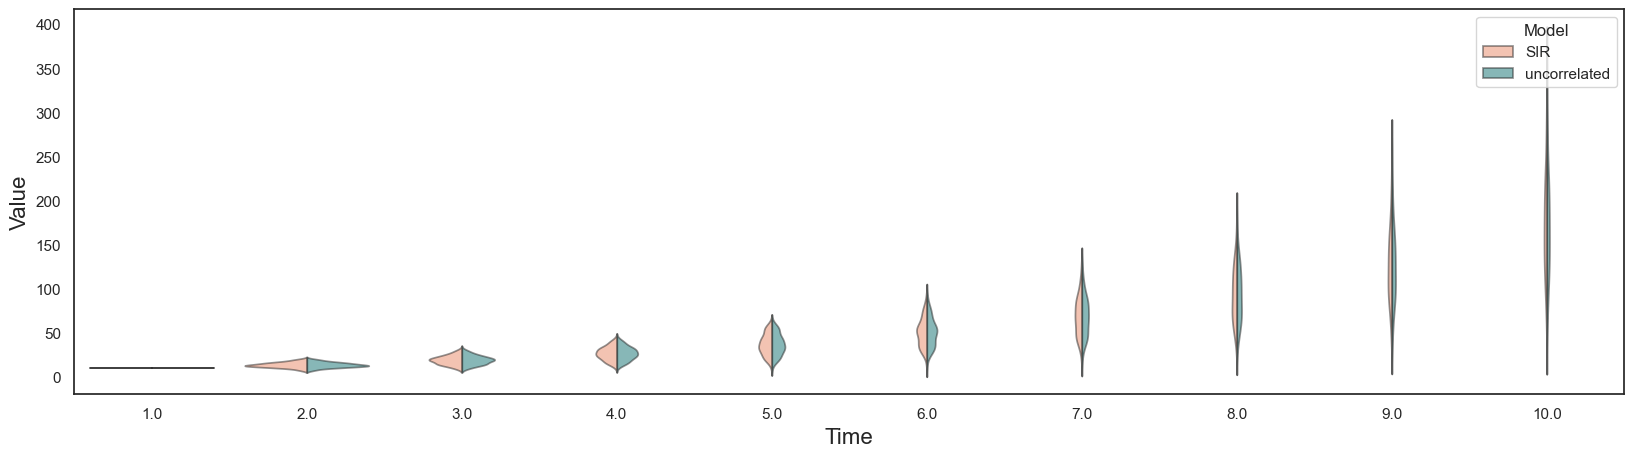

In [15]:
# plot marginal distribution at each time step

dffilt = dftot[dftot.time<11]
palette = ['coral', 'teal']
#sns.color_palette(palette, 2)
sns.set_theme(rc={'figure.figsize':(20,5)}, style='white')
sns.violinplot(x="time", y="I", hue="Model",
            data=dffilt, split=True, inner = None,palette=sns.color_palette(palette, 2), alpha=.5)

plt.xlabel('Time', fontsize=16)
plt.ylabel('Value',fontsize=16)


In [16]:
# run SIR model and generate uncorrelated trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    I_uncorr = pd.DataFrame()
    for t in Idf.time.unique():
        a = list(Idf[Idf.time==t]['I']) 
        val = np.random.choice(a,100, replace=False)

        newrow = pd.DataFrame({'trajectory_id':list(range(1,101)), 'time':np.ones(100)*t, 'I':val})
        I_uncorr = pd.concat([I_uncorr, newrow]) 

    Idf['Model'] = 'SIR'
    I_uncorr['Model'] = 'uncorrelated'

    dftot = pd.concat([Idf, I_uncorr])

    return dftot

In [20]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 200

ES_SIR = []
ES_uncorr = []
WIS_SIR = []
WIS_uncorr = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR']
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    uncorrdf = dftot[dftot.Model=='uncorrelated']
    uncorr_X = np.array([np.array(uncorrdf[uncorrdf['trajectory_id'] == i].I) for i in uncorrdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_uncorr.append(energyscore(uncorr_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_uncorr.append(WIS(uncorr_X,y))
    
    

In [21]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'uncorrelated', 'value':ES_uncorr})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'uncorrelated', 'value':WIS_uncorr})])

526.0293574570678
619.1646071809065
2445.0935152173915
2445.0935152173915


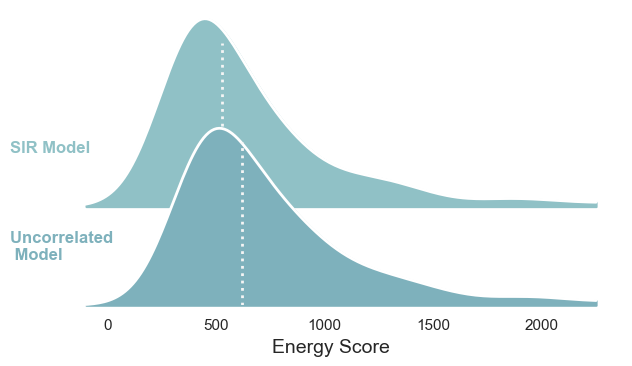

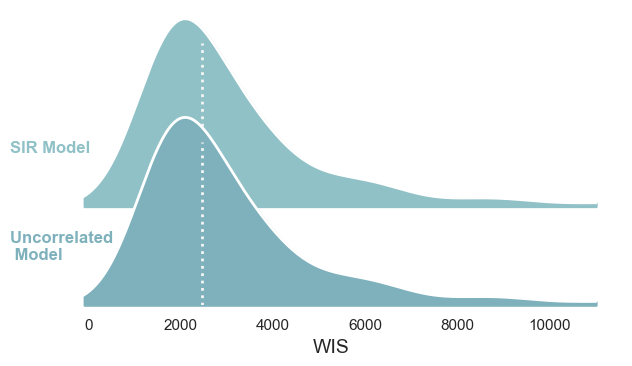

In [22]:
# plot distributions for energy score and WIS

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
dfs = [ESdf, WISdf]
scores = ['Energy Score', 'WIS']

i=1
#plt.subplots(1,2, figsize=(15,5))
for df in dfs:
    if i==1:
        maxi=2250
    else:
        maxi=11000
        
    df = df.copy()
    df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Uncorrelated \n Model')
    #plt.subplot(1,2,i)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Model", hue="Model", aspect=3.5, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "value",
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, clip = (-100,maxi))
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1, clip = (-500,maxi))


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "value")

    # Define a function to plot the median
    def plot_median(data, color, label):
        median = np.median(data['value'])
        plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
        print(median)

    # Apply the function to plot the median
    g.map_dataframe(plot_median)


    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    plt.xlabel(scores[i-1], fontsize=14)
    
   

  #  plt.savefig(f'../figs/dist_SIRtest_{scores[i-1]}.pdf')
    
    
    i+=1
    
    

In [25]:
ESdf['score'] = 'Energy Score'
WISdf['score'] = 'WIS'

allscore = pd.concat([ESdf, WISdf])

allscore['Model'] = allscore['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Uncorrelated Model')

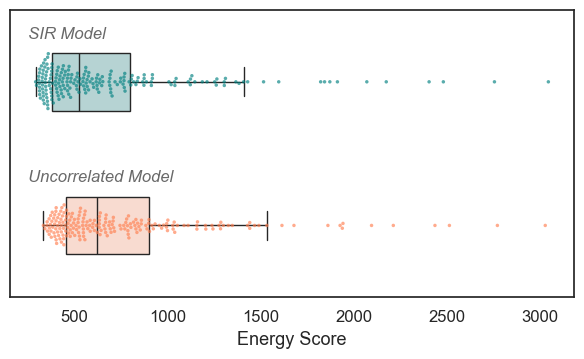

In [26]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']


g=sns.boxplot(x='value', y='Model', data=ESdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=ESdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Uncorrelated Model']:
    plt.text(250,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

#plt.savefig('../figs/sir_test_ES_boxplots.pdf')
plt.show()

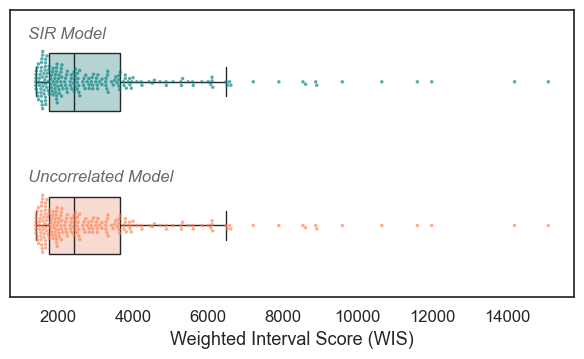

In [27]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']


g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Uncorrelated Model']:
    plt.text(1200,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
#plt.savefig('../figs/sir_test_WIS_boxplots.pdf')
plt.show()